In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.facecolor'] = 'white'
import scipy.interpolate as interpolate
import scipy.stats
from scipy.signal import savgol_filter
from tqdm import tqdm

In [3]:
@njit
def random_config(L, prob=0.5):
    """ Creates a random array of spins with values +1 and -1. Default probability is 0.5 for +1. 
        L: Length of array of spins
    """
    array =  np.ones(L)
    for i in range(L):
        r = np.random.uniform(0,1)
        if r>prob:
            array[i] *= -1

    return array

@njit
def random_config_cont(L):
    """ Creates a random array of spins with values from 0 to -1. 
        L: Length of array of spins
    """
    array =  np.ones(L)
    for i in range(L):
        array[i] = np.random.uniform(0,1)-0.5
    return array

@njit
def Heaviside(x):
    if x>=0:
        return 1
    else:
        return 0

In [4]:
@njit
def p_overlap(spins, pattern):
    p, L = np.shape(pattern)
    m_arr = np.zeros(p)
    for i in range(p):
        m_arr[i] = 1/L * np.sum(spins*pattern[i])
    return m_arr

@njit
def mh_energy(pattern, spins, n):
    p, L = np.shape(pattern)
    E = 0
    for i in range(0,p):
        arr = np.sum(spins*pattern[i])
        E += arr**n
    E *= -1
    return E

@njit
def seq_overlap(spins, pattern):
    p, L = np.shape(pattern)
    m_arr = np.zeros((p,L))
    for pat in range(p):
        for spin in range(L):
            m_arr[pat][spin] = 1/(L-1) * (np.sum(spins*pattern[pat]) - spins[spin]*pattern[pat][spin])
    return m_arr

@njit
def mh_seq_sweep(pattern, spins, T, n, tau, spins_history, run, lambd):
    p, L = np.shape(pattern)
    m_arr = seq_overlap(spins, pattern)
    delay_spins = np.sum(spins_history[(run-tau) : run], axis=0)/tau
    m_arr_delay = seq_overlap(delay_spins, pattern)
    w_sum = np.zeros(L)
    for k in range(p):
        w_sum += lambd*(pattern[(k+1)%p] * m_arr_delay[k]**n) + (pattern[k] * m_arr[k]**n)
    for k in range(L):
        # if w_sum[k]>=0:
        #     spins[k] = 1
        # elif w_sum[k]<0:
        #     spins[k] = -1
        f = 1/(1 + np.exp(-2*w_sum[k]/T))
        r = np.random.uniform(0,1)
        if r<f:
            spins[k] = 1
        else:
            spins[k] = -1
    return spins
        
@njit
def mh_seq_run(pattern, N, T, n, tau, lambd):
    p, L = np.shape(pattern)
    
    initial_spins = pattern[0]
    spins = np.copy(initial_spins)
    
    H_arr = np.zeros(N+1)
    H_arr[0] = mh_energy(pattern, spins, n)
    overlaps = np.zeros((N+1, p))
    overlaps[0] = p_overlap(spins, pattern)
    spins_history = np.zeros((N+1, L))
    spins_history[0] = np.copy(spins)

    for run in range(N):
        spins = mh_seq_sweep(pattern, spins, T, n, tau, spins_history, run, lambd)
        H_arr[run+1] = mh_energy(pattern, spins, n)
        overlaps[run+1] = p_overlap(spins, pattern)
        spins_history[run+1] = np.copy(spins)
        
    return spins_history, pattern, H_arr, overlaps

In [1066]:
%%time
sqr = 15; L = sqr**2
L = 40
num_pat = 50
print("Number of patterns:", num_pat)

# creating random patterns to find
pat_arr =  np.ones((num_pat,L))
for j in range(num_pat):
    pat_arr[j] = random_config(L)

N = 2*5*num_pat

spins_history, pattern, H_arr, overlaps = mh_seq_run(pattern=pat_arr, N=N, T=0.01, n=3, tau=5, lambd=1.5)

Number of patterns: 50
CPU times: user 211 ms, sys: 3.97 ms, total: 215 ms
Wall time: 213 ms


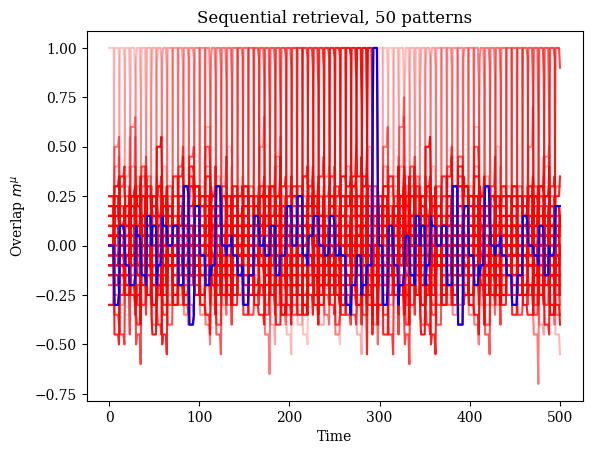

In [1067]:
for i in range(num_pat):
    plt.plot(overlaps[:,i], color='red', alpha=0.2 + ((1-0.2)/num_pat)*i)
plt.plot(overlaps[:,-1], color='blue')

plt.title("Sequential retrieval, "+str(num_pat)+" patterns")
plt.ylabel(r"Overlap $m^{\mu}$")
plt.xlabel("Time")
plt.show()

In [1053]:
@njit
def compress(arr, length):
    l = len(arr)
    new_arr = [arr[0]]
    for i in range(l-1):
        if arr[i] != arr[i+1]:
            new_arr.append(arr[i+1])

    while len(new_arr)<length:
        new_arr.append(new_arr[-1])
    new_arr = new_arr[:length]
        
    return np.array(new_arr)

In [1065]:
max_overlap = np.zeros(len(overlaps))
for i in range(len(overlaps)):
    max_overlap[i] = np.argmax(overlaps[i])
pat_seq = compress(max_overlap, num_pat)
pat_seq

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.])

In [1082]:
%%time
L_range = np.arange(50, 210, 10)
load_param = np.arange(0.1, 3.1, 0.2)
correct = np.zeros((len(L_range), len(load_param)))

iterations = 100

for L_iter in range(len(L_range)):
    L = L_range[L_iter]
    num_pat_range = L*load_param
    for pat_iter in tqdm(range(len(num_pat_range))):
        num_pat = int(num_pat_range[pat_iter])
        N = 5*3*num_pat
        for it in range(iterations):    
            # print(pat_iter, it)
            pat_arr =  np.ones((num_pat,L))
            for j in range(num_pat):
                pat_arr[j] = random_config(L)
                
            spins_history, pattern, H_arr, overlaps = mh_seq_run(pattern=pat_arr, N=N, T=0.01, n=3, tau=5, lambd=10)
            max_overlap = np.zeros(len(overlaps))
            for i in range(len(overlaps)):
                max_overlap[i] = np.argmax(overlaps[i])
            pat_seq = compress(max_overlap, num_pat)
            # print(it, pat_seq)
            if (pat_seq == np.arange(0,num_pat)).all():
                correct[L_iter][pat_iter] += 1

    print(correct[L_iter])

100%|███████████████████████████████████████████| 15/15 [21:44<00:00, 86.99s/it]


[100. 100.  91.  89.  84.  73.  78.  56.  56.  50.  54.  45.  30.  32.
  26.]


100%|████████████████████████████████████████| 15/15 [1:05:22<00:00, 261.49s/it]


[100.  99.  95.  95.  92.  86.  89.  73.  72.  71.  69.  64.  59.  50.
  58.]


100%|████████████████████████████████████████| 15/15 [1:11:49<00:00, 287.28s/it]


[100. 100.  99.  99.  96.  95.  87.  91.  92.  86.  81.  81.  77.  65.
  79.]


 20%|████████▊                                   | 3/15 [01:42<06:49, 34.11s/it]


SystemError: CPUDispatcher(<function mh_seq_run at 0x31ec9be20>) returned a result with an exception set

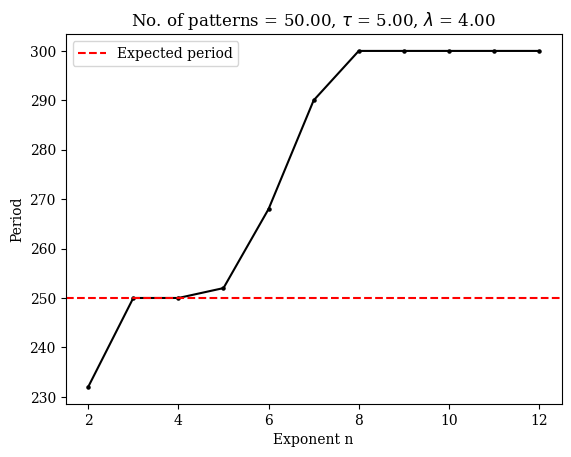

CPU times: user 9.04 s, sys: 34.7 ms, total: 9.07 s
Wall time: 8.96 s


In [276]:
%%time
# Variation of period with n:
L = 100
num_pat = 50
N = 500
tau = 5
lambd = 4

n_range = np.arange(2,13,1)
period = np.zeros_like(n_range)

for n_iter in range(len(n_range)):
    
    pat_arr =  np.ones((num_pat,L))  # creating random patterns to find
    for j in range(num_pat):
        pat_arr[j] = random_config(L)
    spins_history, pattern, H_arr, overlaps = mh_seq_run(pattern=pat_arr, N=N, T=0.01, n=n_range[n_iter], tau=tau, lambd=lambd)
    p1 = overlaps[:,1]; t = 1; found = 0; period_arr = np.zeros(2)
    
    while found<2 and t<len(p1):
        if p1[t] == 1 and p1[t-1]!=1:
            period_arr[found] = t
            found += 1
        t += 1
    period[n_iter] = period_arr[1] - period_arr[0]

plt.scatter(n_range, period, color='black', s=5)
plt.plot(n_range, period, color='black')
plt.axhline(y=tau*num_pat, color='red', ls='--', label='Expected period')
plt.xlabel('Exponent n')
plt.ylabel('Period')
plt.title(r'No. of patterns = %3.2f, $\tau$ = %3.2f, $\lambda$ = %3.2f'%(num_pat, tau, lambd))
plt.legend()
plt.show()

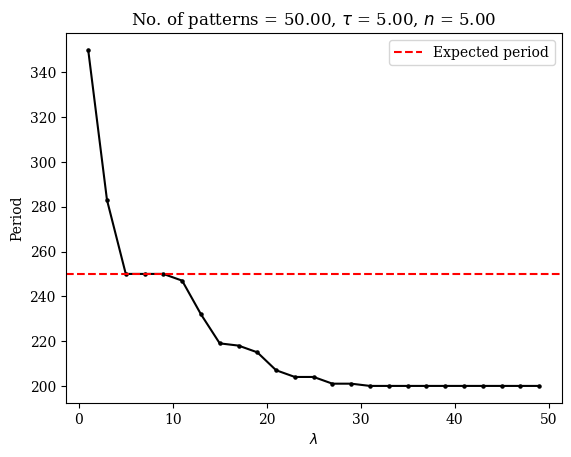

CPU times: user 20.4 s, sys: 47.9 ms, total: 20.5 s
Wall time: 20.4 s


In [274]:
%%time
# Variation of period with lambda:
L = 100
num_pat = 50
N = 500
tau = 5
n = 5

lambd_range = np.arange(1,50,2)
period = np.zeros_like(lambd_range)

for l_iter in range(len(lambd_range)):
    
    pat_arr =  np.ones((num_pat,L))  # creating random patterns to find
    for j in range(num_pat):
        pat_arr[j] = random_config(L)
    spins_history, pattern, H_arr, overlaps = mh_seq_run(pattern=pat_arr, N=N, T=0.01, n=n, tau=tau, lambd=lambd_range[l_iter])
    p1 = overlaps[:,1]; t = 1; found = 0; period_arr = np.zeros(2)
    
    while found<2 and t<len(p1):
        if p1[t] == 1 and p1[t-1]!=1:
            period_arr[found] = t
            found += 1
        t += 1
    period[l_iter] = period_arr[1] - period_arr[0]

plt.scatter(lambd_range, period, color='black', s=5)
plt.plot(lambd_range, period, color='black')
plt.axhline(y=tau*num_pat, color='red', ls='--', label='Expected period')
plt.xlabel(r'$\lambda$')
plt.ylabel('Period')
plt.title(r'No. of patterns = %3.2f, $\tau$ = %3.2f, $n$ = %3.2f'%(num_pat, tau, n))
plt.legend()
plt.show()

In [277]:
from mpl_toolkits.mplot3d import Axes3D

In [610]:
%%time
# Creating data
n_arr = np.arange(1,15,1)
lambd_arr = np.arange(1,50,1)
N, Lambd = np.meshgrid(n_arr, lambd_arr)
temp = 0.9

period_dev = np.zeros((len(lambd_arr), len(n_arr)))
L = 100; num_pat = 20; N_sweeps = 200; tau = 5

for l_iter in tqdm(range(len(lambd_arr))):
    lambd = lambd_arr[l_iter]
    for n_iter in range(len(n_arr)):
        n = n_arr[n_iter]
    
        pat_arr =  np.ones((num_pat,L))  # creating random patterns to find
        for j in range(num_pat):
            pat_arr[j] = random_config(L)
            
        spins_history, pattern, H_arr, overlaps = mh_seq_run(pattern=pat_arr, N=N_sweeps, T=temp, n=n, tau=tau, lambd=lambd)
        p1 = overlaps[:,1]; t = 1; found = 0; period_arr = np.zeros(2)
        
        while found<2 and t<len(p1):
            if p1[t] == 1 and p1[t-1]!=1:
                period_arr[found] = t
                found += 1
            t += 1
        period = period_arr[1] - period_arr[0]
        period_dev[l_iter, n_iter] = np.sqrt((period - tau*num_pat)**2)

100%|███████████████████████████████████████████| 49/49 [01:30<00:00,  1.84s/it]

CPU times: user 1min 29s, sys: 297 ms, total: 1min 29s
Wall time: 1min 30s


In [611]:
%matplotlib qt
# Creating a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the 3D contour
ax.plot_surface(N, Lambd, period_dev, cmap='viridis')

# Customizing the plot
ax.set_xlabel('N')
ax.set_ylabel(r'$\lambda$')
ax.set_zlabel('RMS deviation from true period')
ax.set_title(r'No. of patterns = %3.2f, $\tau$ = %3.2f, T=%3.2f'%(num_pat, tau, temp))

# Displaying the plot
plt.show()

## Pseudo Potential (Pankaj)

In [ ]:
def pseudo_sweep():
    

## Lu and Wu

In [363]:
@njit
def p_overlap(spins, pattern):
    p, L = np.shape(pattern)
    m_arr = np.zeros(p)
    for i in range(p):
        m_arr[i] = 1/L * np.sum(spins*pattern[i])
    return m_arr

@njit
def lw_mh_energy(pattern, spins):
    p, L = np.shape(pattern)
    E = 0
    for i in range(0,p):
        arr = np.sum(spins*pattern[i])
        E += arr**2
    E *= -1
    return E

@njit
def lw_sweep(spins, hidden, U, V):
    N = len(spins)
    M = len(hidden)
    for i in range(M):
        hidden[i] = np.sign(np.sum(U[i]*spins))
    for j in range(N):
        spins[j] = np.sign(np.sum(V[j]*hidden))
    return spins, hidden
    
@njit
def lw_mh_run(pattern, N, M, T, eta, epochs=10, sweeps=1_000):
    """
    pattern: Array of sequence patterns to be retrived in order
    N: Number of visible neurons
    M: Number of hidden neurons
    T: Temperature of the system
    eta: Learning rate hyperparameter
    """
    p, N = np.shape(pattern)
    
    initial_spins = pattern[0]#random_config(N)
    spins = np.copy(initial_spins)
    hidden = random_config(M)
    
    H_arr = np.zeros(sweeps+1)
    H_arr[0] = lw_mh_energy(pattern, spins)
    overlaps = np.zeros((sweeps+1, p))
    overlaps[0] = p_overlap(spins, pattern)
    spins_history = np.zeros((sweeps+1, N))
    spins_history[0] = np.copy(spins)
    
    U = np.random.normal(0, 1e-6, (M,N))
    V = np.random.normal(0, 1e-6, (N,M))
    P = np.random.normal(0, 1e-6, (M,N))
    
    for e in range(epochs):
        for p_no in range(p):
            y_t = np.zeros(M)
            for i in range(M):     
                z_i_tp1 = np.sign(np.sum(P[i]*pattern[(p_no+1)%p]))
                mu_i_t = Heaviside(1 - z_i_tp1 * np.sum(U[i]*pattern[p_no]))
                U[i] = U[i] + eta * mu_i_t * z_i_tp1 * pattern[p_no]
                y_t[i] = np.sign(np.sum(U[i]*pattern[p_no]))
    
                for j in range(N):
                    nu_j_t = Heaviside(1 - pattern[(p_no+1)%p][j] * np.sum(V[j]*y_t))
                    V[j][i] = V[j][i] + eta * nu_j_t * pattern[(p_no+1)%p][j] * y_t[i]
    
    for run in range(sweeps):
        spins, hidden = lw_sweep(spins, hidden, U, V)
        H_arr[run+1] = lw_mh_energy(pattern, spins)
        overlaps[run+1] = p_overlap(spins, pattern)
        spins_history[run+1] = np.copy(spins)
        
    return spins_history, pattern, H_arr, overlaps

In [366]:
%%time
N = 10
num_pat = 5
print("Number of patterns:", num_pat)

# creating random patterns to find
pat_arr =  np.ones((num_pat,N))
for j in range(num_pat):
    pat_arr[j] = random_config(N)

spins_history, pattern, H_arr, overlaps = lw_mh_run(pattern=pat_arr, N=N, M=50, T=0.01, eta=1e-3, epochs=1000, sweeps=5*num_pat)

Number of patterns: 5
CPU times: user 344 ms, sys: 2.19 ms, total: 346 ms
Wall time: 344 ms


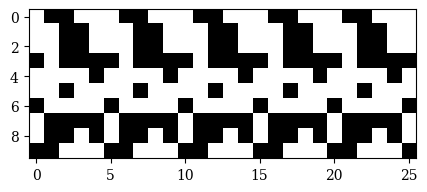

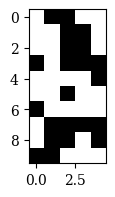

In [369]:
%matplotlib inline
# plt.imshow(spins_history[0:num_pat].T-spins_history[num_pat:2*num_pat].T, cmap='Greys_r')
plt.figure(figsize=(5,2))
plt.imshow(spins_history.T, cmap='Greys_r')
plt.show()
plt.figure(figsize=(1,2))
plt.imshow(pattern.T, cmap='Greys_r')
plt.show()

## Branching sequences

In [11]:
@njit
def p_overlap(spins, pattern):
    p, L = np.shape(pattern)
    m_arr = np.zeros(p)
    for i in range(p):
        m_arr[i] = 1/L * np.sum(spins*pattern[i])
    return m_arr

@njit
def mh_energy(pattern, spins, n):
    p, L = np.shape(pattern)
    E = 0
    for i in range(0,p):
        arr = np.sum(spins*pattern[i])
        E += arr**n
    E *= -1
    return E

@njit
def seq_overlap(spins, pattern):
    p, L = np.shape(pattern)
    m_arr = np.zeros((p,L))
    for pat in range(p):
        for spin in range(L):
            m_arr[pat][spin] = 1/(L-1) * (np.sum(spins*pattern[pat]) - spins[spin]*pattern[pat][spin])
    return m_arr

# @njit
def branch_seq_sweep(pattern, spins, T, n, tau, spins_history, run, lambd):
    p, L = np.shape(pattern)
    m_arr = seq_overlap(spins, pattern)
    delay_spins = np.sum(spins_history[(run-tau) : run], axis=0)/tau
    m_arr_delay = seq_overlap(delay_spins, pattern)
    w_sum = np.zeros(L)
    for k in range(p):
        w_sum += (pattern[k] * m_arr[k]**n)  # stability term
    
    for k in range(L):
        w_sum[k] += np.sum(np.matmul(lambd[:,:,k], m_arr_delay[:,k]**n))
        # spins[k] = np.tanh(w_sum[k]/T)
        f = 1/(1 + np.exp(-2*w_sum[k]/T))
        r = np.random.uniform(0,1)
        if r<f:
            spins[k] = 1
        else:
            spins[k] = -1
    return spins
        
# @njit
def branch_seq_run(pattern, N, T, n, tau, lambd, start=0):
    p, L = np.shape(pattern)
    
    initial_spins = pattern[start]
    spins = np.copy(initial_spins)
    
    H_arr = np.zeros(N+1)
    H_arr[0] = mh_energy(pattern, spins, n)
    overlaps = np.zeros((N+1, p))
    overlaps[0] = p_overlap(spins, pattern)
    spins_history = np.zeros((N+1, L))
    spins_history[0] = np.copy(spins)
    
    for run in range(N):
        spins = branch_seq_sweep(pattern, spins, T, n, tau, spins_history, run, lambd)
        H_arr[run+1] = mh_energy(pattern, spins, n)
        overlaps[run+1] = p_overlap(spins, pattern)
        spins_history[run+1] = np.copy(spins)
        
    return spins_history, pattern, H_arr, overlaps

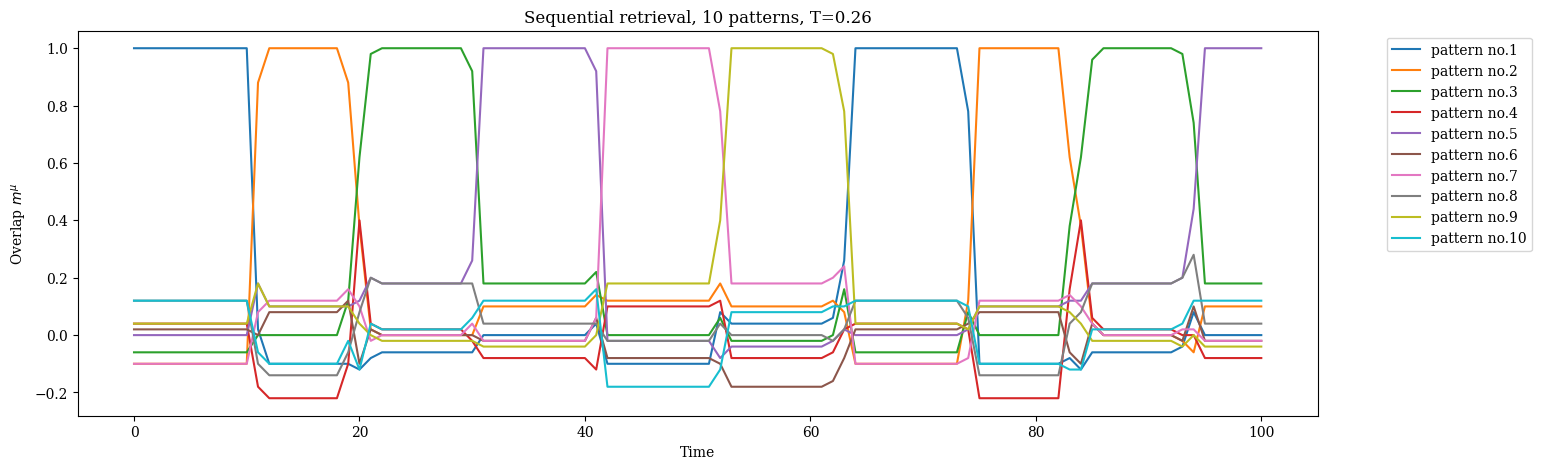

CPU times: user 901 ms, sys: 38 ms, total: 939 ms
Wall time: 719 ms


In [6]:
%%time
# %matplotlib inline
L = 100
num_pat = 10

# creating random patterns to find
pat_arr =  np.ones((num_pat,L))
for j in range(num_pat):
    pat_arr[j] = random_config(L)

N = 100
lambda_matrix = np.zeros((num_pat, num_pat, L))

sequence = np.array([[1,2,1], [2,3,1], [2,4,1], [3,5,1], [4,6,1], [5,7,1], [6,8,1], [7,9,1], [8,10,1], [9,1,1], [10,1,1]])

for x in range(len(sequence)):
    a, b, w = sequence[x]
    a = a-1; b = b-1
    row = int((b-a)%num_pat); col = int(a)
    lambda_matrix[row, col] = w*1.1 * pat_arr[int(b)]

spins_history, pattern, H_arr, overlaps = branch_seq_run(pattern=pat_arr, N=N, T=0.10, n=2, tau=10, lambd=lambda_matrix)

plt.figure(figsize=(16,5))
for i in range(num_pat):
    plt.plot(overlaps[:,i], label='pattern no.'+str(i+1))

plt.title("Sequential retrieval, "+str(num_pat)+" patterns, T=0.26")
plt.ylabel(r"Overlap $m^{\mu}$")
plt.xlabel("Time")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [12]:
%%time
L = 100
N = 80
iterations = 50
path_arr = np.zeros((iterations, N+1))

for it in range(iterations):
    
    sequence = np.array([[10,11,1], [11,19,1], [11,5,1], [19,16,1], [19,21,1], [16,17,1], [16,15,1], [21,22,1], [21,20,1], [5,7,1], [5,3,1], [3,4,1], [3,2,1], [7,8,1], [7,6,1]])
    # sequence = np.array([[4,5,1], [5,6,1], [6,7,1], [4,3,1], [3,2,1], [2,1,1]])
    # sequence = np.array([[4,5,1], [4,3,1], [5,6,1], [6,7,1], [6,8,1], [7,9,1], [7,10,1], [8,11,1], [8,12,1], [9,13,1], [9,14,1], [3,2,1], [2,1,1]])
    num_pat = int(np.max(sequence))
    lambda_matrix = np.zeros((num_pat, num_pat, L))

    pat_arr =  np.ones((num_pat,L))
    for j in range(num_pat):
        pat_arr[j] = random_config(L)
    
    for x in range(len(sequence)):
        a, b, w = sequence[x]
        a = a-1; b = b-1
        row = int((b-a)%num_pat); col = int(a)
        lambda_matrix[row, col] = w*1.5 * pat_arr[int(b)]
    
    spins_history, pattern, H_arr, overlaps = branch_seq_run(pattern=pat_arr, N=N, T=0.01, n=3, tau=10, lambd=lambda_matrix, start=9)
    
    for i in range(N+1):
        guess = np.argmax(overlaps[i])
        # if overlaps[i][guess]>=0.9:
        path_arr[it][i] = guess

/var/folders/s6/fhwtdfyn747fnvt3zjt3flgh0000gq/T/ipykernel_90066/1249740185.py:41: RuntimeWarning: overflow encountered in exp
  f = 1/(1 + np.exp(-2*w_sum[k]/T))


CPU times: user 4.03 s, sys: 20.3 ms, total: 4.05 s
Wall time: 4.06 s


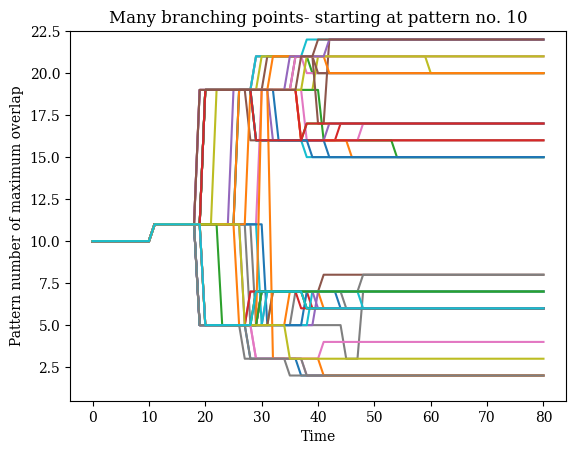

In [8]:
n_b1 = 0
n_b2 = 0
for i in range(iterations):
    if path_arr[i][-1] == 0:
        n_b1 +=1
    elif path_arr[i][-1] == num_pat-1:
        n_b2 +=1
    plt.plot(path_arr[i]+1)
    plt.ylim(0.5, num_pat+0.5)

plt.xlabel('Time')
plt.ylabel('Pattern number of maximum overlap')
plt.title(r'Many branching points- starting at pattern no. 10')
# plt.text(0, 1, r"$\lambda_{4-5} = 1.21$, %3.2f trials" "\n" r"$\lambda_{4-3} = 1.1$, %3.2f trials"%(n_b2, n_b1))
plt.show()
# print(n_b1, n_b2)

## Checking capacity

In [909]:
%%time
L_range = np.arange(5,200,15)
errors = np.zeros_like(L_range)
N = 200
iterations = 200
sequence = np.array([[4,5,1], [4,3,1], [5,6,1], [6,7,1], [6,8,1], [7,9,1], [7,10,1], [8,11,1], [8,12,1], [9,13,1], [9,14,1], [3,2,1], [2,1,1]])
forbidden = np.array([2,3,4,5,6,7,8,9]) - 1

for L_count in tqdm(range(len(L_range))):
    L = L_range[L_count]
    
    for it in range(iterations):
        path_arr = np.zeros((iterations, N+1))
        num_pat = np.max(sequence)
        lambda_matrix = np.zeros((num_pat, num_pat, L))
        
        pat_arr =  np.ones((num_pat,L))
        for j in range(num_pat):
            pat_arr[j] = random_config(L)
        
        for x in range(len(sequence)):
            a, b, w = sequence[x]
            row = int((b-a)%num_pat); col = int(a-1%num_pat)
            lambda_matrix[row, col] = w*1.1 * pat_arr[(col+row)%num_pat]
        
        spins_history, pattern, H_arr, overlaps = branch_seq_run(pattern=pat_arr, N=N, T=0.01, n=4, tau=10, lambd=lambda_matrix, start=3)
        
        for i in range(N+1):
            path_arr[it][i] = np.argmax(overlaps[i])
        
        if (path_arr[it][-1] == forbidden).any():
            errors[L_count] += 1

  0%|                                                    | 0/13 [00:00<?, ?it/s]/var/folders/s6/fhwtdfyn747fnvt3zjt3flgh0000gq/T/ipykernel_99373/1249740185.py:41: RuntimeWarning: overflow encountered in exp
  f = 1/(1 + np.exp(-2*w_sum[k]/T))
100%|███████████████████████████████████████████| 13/13 [09:36<00:00, 44.37s/it]

CPU times: user 9min 35s, sys: 1.11 s, total: 9min 36s
Wall time: 9min 36s


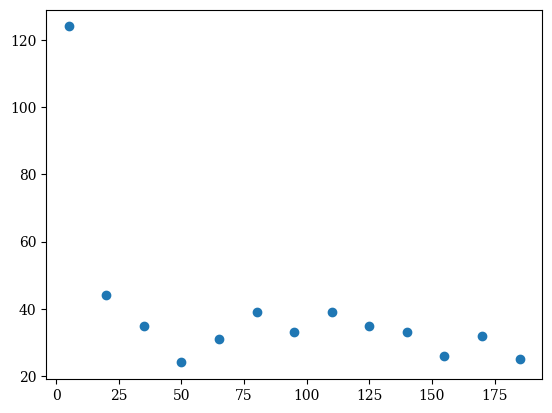

In [910]:
plt.scatter(L_range, errors)

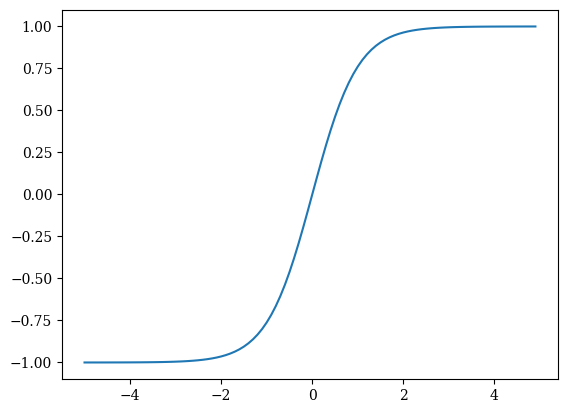

In [829]:
a = np.arange(-5,5,0.1)
b = np.tanh(a/1)
plt.plot(a,b)